In [1]:
library("dplyr")
library("ggplot2")

setwd("/media/scott/Zapdos/angela_prss3")

hp <- read.csv("merged_mi_pi_sample_KI270803v1_770437-790564_PASS_gt_amended_hap_common_vars_vectors.txt", 
                              sep = "\t", header=FALSE )
ph <- read.csv("rs3757377_dup_phased_gt.txt", sep = "\t", header = TRUE, check.names = FALSE)

#co <- read.csv("var_coef_KI270803v1_770437-790564.txt", sep = "\t", header = TRUE, check.names = FALSE)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in file(file, "rt"):
“cannot open file 'merged_mi_pi_sample_KI270803v1_770437-790564_PASS_gt_amended_hap_common_vars_vectors.txt': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [2]:
#extract rsids
vids <- hp[,c(1,2)]
colnames(vids) <- c("pos", "id")
vids <- vids[c(-1,-2),]
vids$id <- as.character(vids$id)
vids$pos <- as.numeric(as.character(vids$pos))

#haplotype df
haps <- apply(hp, 2, as.character)
colnames(haps) <- haps[1,]
colnames(haps)[1] <- "pos"
haps <- haps[c(-1, -2),-2]
haps <- as.data.frame(apply(haps, 2, as.numeric))

#haplotype matrix
hap.matrix <- haps
row.names(hap.matrix) <- haps[,1] 
hap.matrix <- as.matrix(hap.matrix[,-1])

#phenotype data
phen <- ph[,c(1,2,3,4)]
colnames(phen) <- c("sample", "dup", "rs_alt_count", "mi")
phen$mi <- as.factor(phen$mi)

ERROR: Error in eval(expr, envir, enclos): object 'hp' not found


### Clean Data

In [3]:
af <- function(p){
    gt <- t(haps[haps$pos == p,][,2:ncol(haps)])
    if(length(gt) < 1){
        print(p)
        return(0)
        
    }
    v <- as.vector(gt[,1])
    print(paste(p, mean(v)))
    return(mean(v))
}

pos <- vids$pos
sig.pos <- read.csv("sig_pos_new.bed", sep = "\t", header = F)$V2

#lapply(sig.pos, FUN=af)

ERROR: Error in eval(expr, envir, enclos): object 'vids' not found


In [4]:
#variant data
coef <- co
colnames(coef)[1] <- "pos"
count <- rowSums(hap.matrix, na.rm=TRUE)
minor_count <- pmin(count, nrow(haps) - count)
countdf <- data.frame(count, minor_count)
countdf$pos <- rownames(countdf)
coef <- merge(coef, countdf, by="pos")

ERROR: Error in eval(expr, envir, enclos): object 'co' not found


### Helper Functions

In [5]:
get.top <- function(n=-1, cut=-1){
    
    if (n > 0){
        top <- top_n(coef, n, neg_log10p_snp)$pos
    }
    
    if (cut > 0){
        top <- coef[coef$p_snp < cut,]$pos
    }
        
    haptable <- t(haps[haps$pos %in% top,])
    colnames(haptable) <- haptable[1,]
    haptable <- haptable[-1,]
        
    split <- function(x){
        v = strsplit(x, "_")[[1]]
        if (length(v) == 2 || grepl("hap", v[2])){
            return(v[1])
        }

        a = strsplit(x, "_")[[1]][1]
        b = strsplit(x, "_")[[1]][2]
      return(paste(a, b, sep="_"))
    }
    rownames(haptable) <- lapply(rownames(haptable), split)
    return(haptable)
}

sum.all <- function(sample){
    return(sum(haptable[rownames(haptable) == sample,]))   
}
count.zero <- function(sample){
    return(sum(haptable[rownames(haptable) == sample,] == 0))   
}
count.zero.hap <- function(sample){
    rsums <- rowSums(haptable==0)
    rsums <- as.vector(rsums[names(rsums) == sample])

    if(length(rsums) ==1)
        rsums <- c(rsums, 0)
    return(rsums)
}

collapse.haps <- function(i){
    return(paste(haptable[i,],collapse=""))   
}
get.dup <- function(sample){
    return(phen[phen$sample == sample,]$dup)
}
get.mi <- function(sample){
 return(as.numeric(as.character(phen[phen$sample == sample,]$mi)))
}

### Analysis

In [9]:
haptable <- get.top(n=20)
#haptable <- get.top(cut=0.05)

ids <- unique(rownames(haptable))

mi.status <- sapply(ids, get.mi)
dup.status <- sapply(ids, get.dup)
saturation <- sapply(ids, sum.all)
saturation <- saturation/(n*dup.status)

#mi.status
#print("----------")
#saturation

model=glm(mi.status~saturation, family="binomial")
summary(model)

df <- data.frame(mi=mi.status, alt_saturation=saturation)
ggplot(df, aes(x=alt_saturation, fill=as.factor(mi.status))) +
  geom_histogram(bins=100) + theme_bw() +
  xlab("Alternative allele saturation\n(# alt alleles / total # alt alleles possible)") + 
  ylab("# individuals") + labs(fill = "MI status")

ERROR: Error in UseMethod("filter_"): no applicable method for 'filter_' applied to an object of class "function"


In [7]:
haptable <- get.top(n=20)
#haptable <- get.top(cut=0.05)

ids <- unique(rownames(haptable))

mi.status <- sapply(ids, get.mi)
dup.status <- sapply(ids, get.dup)
zeros <- sapply(ids, count.zero)

model=glm(mi.status~zeros,#+dup.status,
          family="binomial")
summary(model)

df <- data.frame(mi=mi.status, zeros=zeros)
ggplot(df, aes(x=zeros, fill=as.factor(mi.status))) +
  geom_histogram(bins=100) + theme_bw() +
  xlab("total # reference alleles") + 
  ylab("# individuals") + labs(fill = "MI status")

#mi.status
#print("----------")
#zeros

ERROR: Error in UseMethod("filter_"): no applicable method for 'filter_' applied to an object of class "function"


In [50]:
hapcodes <- sapply(1:nrow(haptable), collapse.haps)
#haptable[colnames(haptable) == "776553",]

pos=778261

df = as.data.frame(haptable)
samps = rownames(df)[df[,colnames(df) == pos ] == 0]
samps

phen[phen$sample %in% samps,]
#phen[phen$sample %in% c("OSK7142_03A"),]


ERROR: Error in nrow(haptable): object 'haptable' not found


[1] 259 717

[1] "character"

Warning message in file(file, "rt"):
“cannot open file 'var_coef_KI270803v1_770437-790564.txt': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


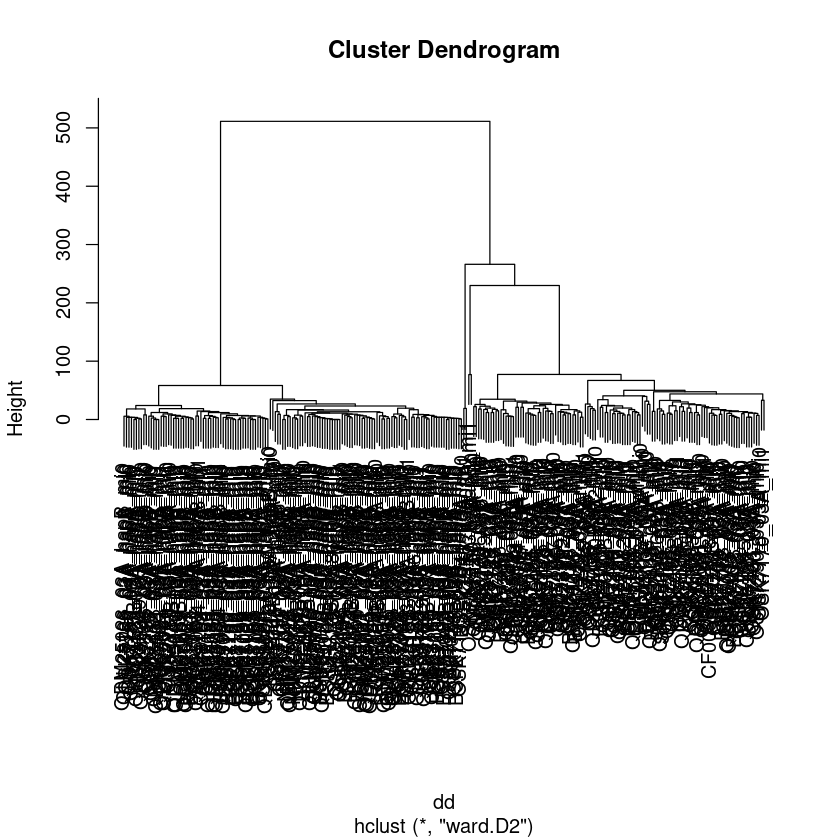

In [51]:
library(ggplot2)

haplotype_vectors <- read.csv("merged_mi_pi_sample_KI270803v1_770437-790564_PASS_gt_amended_hap_common_vars_vectors.txt", 
                              sep = "\t", header=FALSE )

#transpose dataframe
haplotype_vectors <- data.frame(t(haplotype_vectors))
haplotype_vectors <- apply(haplotype_vectors, 2, as.character)


col_names <- haplotype_vectors[1,][-1]
row_names <- haplotype_vectors[,1][c(-1, -2)]


haplotype_vectors <- haplotype_vectors[c(-1, -2),-1]  
dim(haplotype_vectors)
class(haplotype_vectors[[4]])
haplotype_vectors <- data.frame(haplotype_vectors)
haplotype_vectors[,-1] <- apply(haplotype_vectors[,-1], 2, as.numeric)

row.names(haplotype_vectors) <- row_names
colnames(haplotype_vectors) <- col_names



#cluster haplotypes
dd <- dist(haplotype_vectors, method = "manhattan")
hc <- hclust(dd, method = "ward.D2")
hap_order <- hc$order
plot(hc)

coef <- read.csv("var_coef_KI270803v1_770437-790564.txt", sep = "\t", header = TRUE, check.names = FALSE)




col_sum <- sapply(haplotype_vectors[,-1], function(x) sum(x))
var_data <- cbind(haplotype_vectors[,1], haplotype_vectors[,col_sum >= 5])

coef <- coef[coef[,1] %in% colnames(var_data[-1]), ]



heat_value <- t(var_data[,-1])
heat_value <- heat_value[, hap_order]
heat_value <- apply(heat_value, 2, function(x) ifelse (x ==1,x <- coef[,4], NA))
heat_value <- cbind(as.numeric(row.names(heat_value)), heat_value)
colnames(heat_value)[1] <- "pos" 
heat_value <- data.frame(heat_value)

#heat_value <- rbind(row.names(heat_value), heat_value)

library(reshape2)
a <- melt(heat_value)
colnames(a) <- c("pos", "sample", "p_snp")
# Heatmap 
ggplot(a, aes(pos, sample, fill = p_snp)) + 
  geom_tile() +
  scale_fill_gradient(high = "blue", low="red", limits=c(0,0.5), , oob = scales::squish) +
  guides(fill = guide_legend(size = 30)) +
  labs(x="\nKI270803v1 positions\n", y="Individual haplotyoes\n", title="PRSS Insertion haplotyes\n", 
       fill ="p_snp" ) 
  theme( 
         axis.text.x = element_text(size = 20, angle = 90, vjust = 0.5, hjust=1),
         axis.text.y = element_text(size = 20),
         axis.title.y = element_text(size = 30),
         axis.title.x = element_text(size = 20),
         plot.title = element_text(size=20),
        legend.text=element_text(size=40),
        legend.title = element_text(size=50))




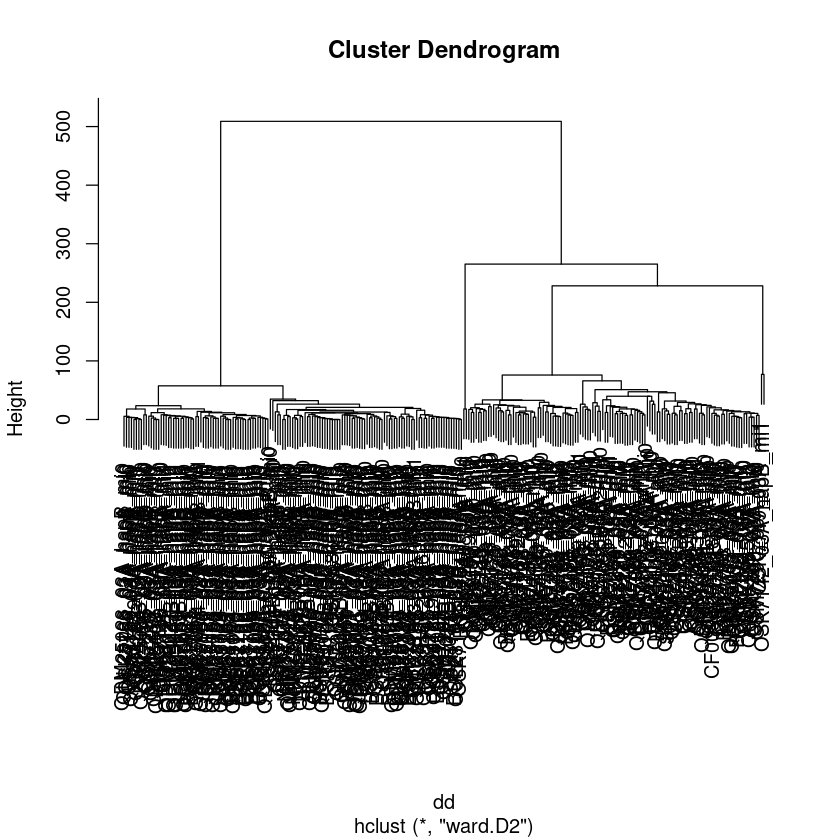

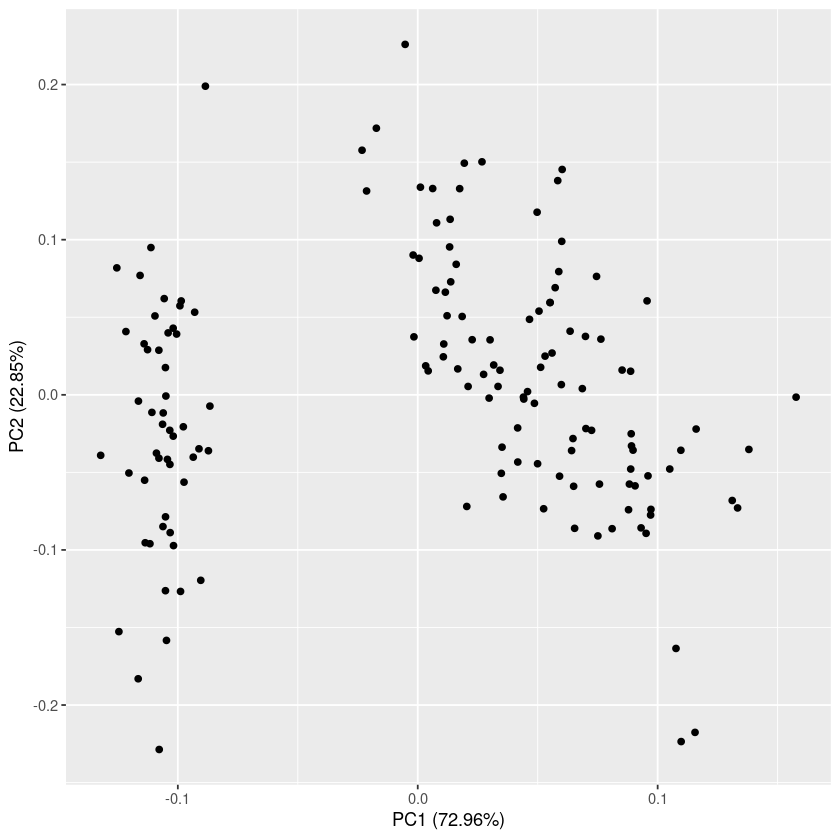

In [52]:
#cluster haplotypes
dd <- dist(t(hap.matrix), method = "manhattan")
hc <- hclust(dd, method = "ward.D2")
hap_order <- hc$order
plot(hc)

library("ggfortify")
df <- iris[1:4]
pca_res <- prcomp(df, scale. = TRUE)

autoplot(pca_res)

In [49]:
haptable <- get.top(n=20)
#haptable <- get.top(cut=0.05)

count.zero.hap <- function(sample){
    rsums <- rowSums(haptable==0)
    rsums <- as.vector(rsums[names(rsums) == sample])
    if(length(rsums) ==1)
        rsums <- c(rsums, 0)

    return(rsums)
}

ids <- unique(rownames(haptable))

mi.status <- sapply(ids, get.mi)
dup.status <- sapply(ids, get.dup)
zeros.haps <- t(as.data.frame(lapply(ids, count.zero.hap)))
rownames(zeros.haps) <- NULL
colnames(zeros.haps) <- c("h1", "h2")
zeros.haps <- as.data.frame(zeros.haps)

#df1 <- data.frame(mi=mi.status, dup=dup.status, zeros=zeros.haps$h1)
#df2 <- data.frame(mi=mi.status, dup=dup.status, zeros=zeros.haps$h2)
#df <- rbind(df1, df2)

#model=glm(df$mi ~ df$zeros + df$dup, family="binomial")
#summary(model)

colour <- rep("skyblue", length(ids))
colour[mi.status == 1] <- "orange"
plot(jitter(zeros.haps$h1), jitter(zeros.haps$h2),col=colour)

#print(zeros.haps)

ERROR: Error in UseMethod("filter_"): no applicable method for 'filter_' applied to an object of class "function"


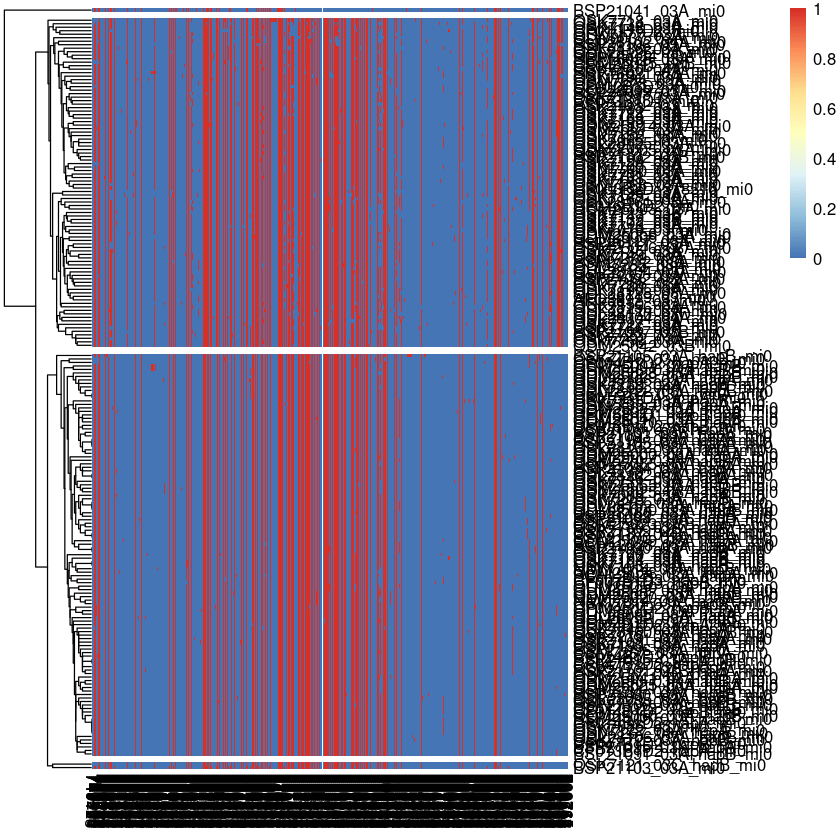

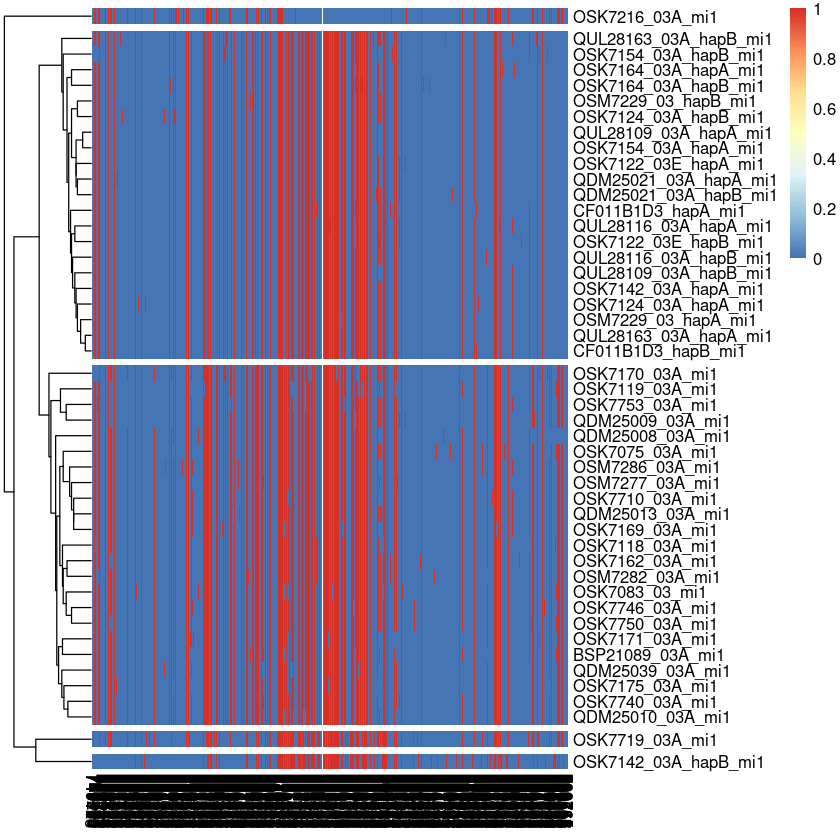

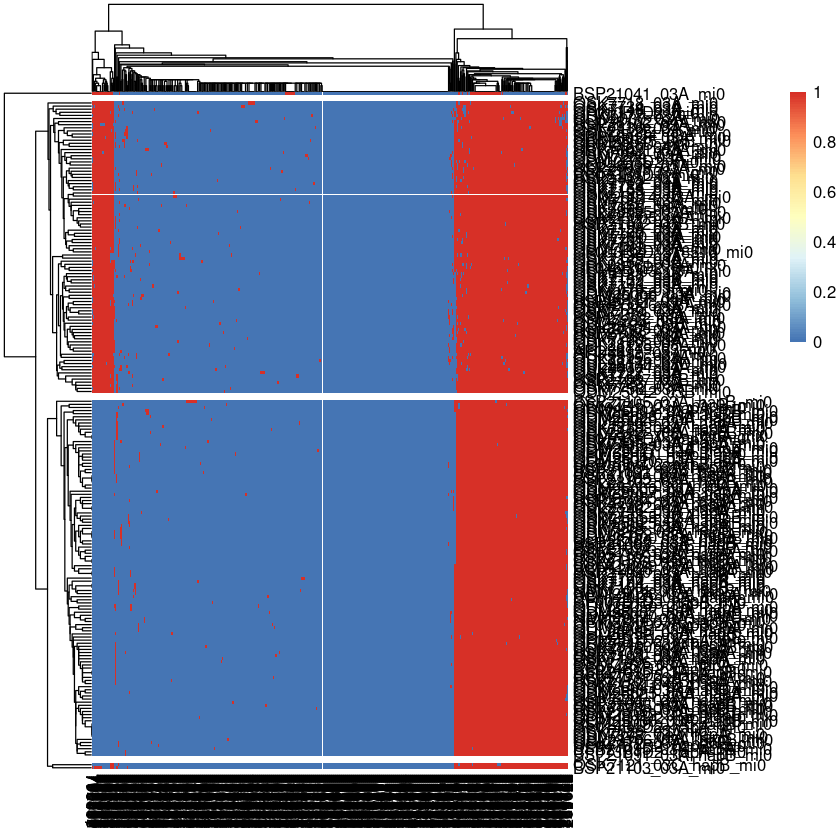

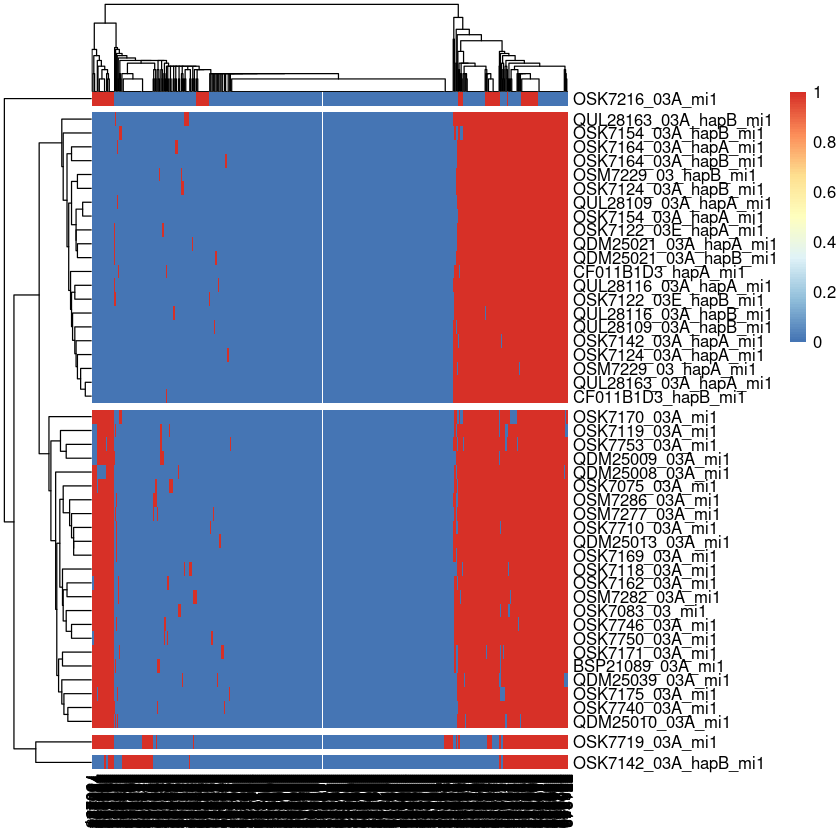

In [57]:
library("pheatmap")

underscore.split <- function(x){
    return(strsplit(x, "_")[[1]][1])      
}


mi0 <- lapply(as.character(phen[phen$mi == 0,]$sample), FUN=underscore.split)
mi1 <- lapply(as.character(phen[phen$mi == 1,]$sample), FUN=underscore.split)

hap0 <- hap.matrix[, lapply(colnames(hap.matrix), FUN=underscore.split) %in% mi0]
hap1 <- hap.matrix[, lapply(colnames(hap.matrix), FUN=underscore.split) %in% mi1]

pheatmap(t(hap0), cluster_cols=FALSE, cutree_rows = 4)
pheatmap(t(hap1), cluster_cols=FALSE, cutree_rows = 5)

pheatmap(t(hap0), cutree_rows = 4)
pheatmap(t(hap1), cutree_rows = 5)


#pheatmap(t(hap0), cluster_cols=FALSE, cutree_rows = 4)
#pheatmap(t(hap1), cluster_cols=FALSE, cutree_rows = 5)

persamp=2
pervariant=2


In [58]:
png("/media/scott/Zapdos/angela_prss3/rplot0_.png", width=nrow(hap.matrix)*pervariant, height=ncol(hap0)*persamp)
pheatmap(t(hap0), cluster_cols=FALSE, cutree_rows = 4)
dev.off()

png 
  3

In [59]:
png("rplot1_.png", width=nrow(hap.matrix)*pervariant, height=ncol(hap1)*persamp)
pheatmap(t(hap1), cluster_cols=FALSE, cutree_rows = 5)
dev.off()


png 
  3

In [64]:
phen[phen$sample == "OSM7216_03",]

,sample,dup,rs_alt_count,mi
,<fct>,<int>,<int>,<fct>
12,OSM7216_03,0,0,0
